# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float32) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float32) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [23]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [34]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int).reshape(1, -1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [38]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(float)
target_index = np.ones(batch_size, dtype=int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [39]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [40]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 906.875189
Epoch 1, loss: 825.588913
Epoch 2, loss: 902.880364
Epoch 3, loss: 827.801506
Epoch 4, loss: 941.855854
Epoch 5, loss: 880.560729
Epoch 6, loss: 943.684482
Epoch 7, loss: 1026.816850
Epoch 8, loss: 930.310760
Epoch 9, loss: 824.881920


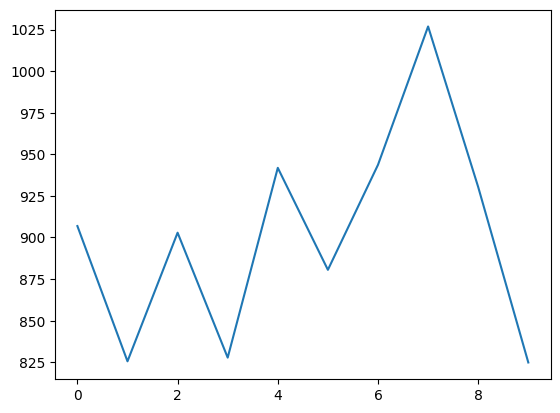

In [41]:
# let's look at the loss history!
plt.plot(loss_history)

In [44]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.15
Epoch 0, loss: 957.197835
Epoch 1, loss: 762.080095
Epoch 2, loss: 1014.447648
Epoch 3, loss: 868.023872
Epoch 4, loss: 981.566897
Epoch 5, loss: 788.060215
Epoch 6, loss: 729.204651
Epoch 7, loss: 899.792240
Epoch 8, loss: 837.301030
Epoch 9, loss: 853.895671
Epoch 10, loss: 841.146115
Epoch 11, loss: 885.066120
Epoch 12, loss: 965.587200
Epoch 13, loss: 1018.777317
Epoch 14, loss: 872.095020
Epoch 15, loss: 794.061886
Epoch 16, loss: 915.652934
Epoch 17, loss: 771.005088
Epoch 18, loss: 906.534056
Epoch 19, loss: 833.908113
Epoch 20, loss: 793.153324
Epoch 21, loss: 948.240102
Epoch 22, loss: 802.878428
Epoch 23, loss: 837.346457
Epoch 24, loss: 718.400796
Epoch 25, loss: 927.599381
Epoch 26, loss: 925.029793
Epoch 27, loss: 872.038027
Epoch 28, loss: 992.073712
Epoch 29, loss: 899.116682
Epoch 30, loss: 735.088842
Epoch 31, loss: 1060.131067
Epoch 32, loss: 883.230770
Epoch 33, loss: 856.332460
Epoch 34, loss: 904.385127
Epoch 35, loss: 874.907995
Epoch 36, loss: 817

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [51]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

# train_folds_x = np.split(train_X, batch_size)
# train_folds_y = np.split(train_y, batch_size)

best_classifier = None
best_val_accuracy = 0.0

for lr in learning_rates:
    for reg in reg_strengths:
#         sub_train_x = np.concatenate(train_folds_x[1:])
#         sub_train_y = np.concatenate(train_folds_x[1:])
        classifier = linear_classifer.LinearSoftmaxClassifier()
#         classifier.fit(sub_train_x, sub_train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
        
#         pred = classifier.predict(train_folds_x[0])
        pred = classifier.predict(test_X)
#         accuracy = multiclass_accuracy(pred, train_folds_y[0])
        accuracy = multiclass_accuracy(pred, test_y)
        
        print(f'lr: {lr} | reg: {reg} | accuracy: {accuracy}')
        
        if accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 1058.794767
Epoch 1, loss: 921.823509
Epoch 2, loss: 906.006988
Epoch 3, loss: 935.559478
Epoch 4, loss: 810.942937
Epoch 5, loss: 728.951552
Epoch 6, loss: 963.570926
Epoch 7, loss: 834.896203
Epoch 8, loss: 885.470464
Epoch 9, loss: 824.065783
Epoch 10, loss: 852.038229
Epoch 11, loss: 865.104587
Epoch 12, loss: 680.933200
Epoch 13, loss: 922.541473
Epoch 14, loss: 851.217759
Epoch 15, loss: 640.426259
Epoch 16, loss: 828.102927
Epoch 17, loss: 732.902943
Epoch 18, loss: 822.604280
Epoch 19, loss: 760.913547
Epoch 20, loss: 879.098526
Epoch 21, loss: 790.867654
Epoch 22, loss: 685.039623
Epoch 23, loss: 864.984825
Epoch 24, loss: 685.264088
Epoch 25, loss: 886.633361
Epoch 26, loss: 644.402048
Epoch 27, loss: 771.837225
Epoch 28, loss: 784.187721
Epoch 29, loss: 912.971698
Epoch 30, loss: 908.594390
Epoch 31, loss: 866.471491
Epoch 32, loss: 741.179540
Epoch 33, loss: 920.949534
Epoch 34, loss: 878.463702
Epoch 35, loss: 818.673886
Epoch 36, loss: 818.699198
Epoch 37, 

Epoch 99, loss: 754.100706
Epoch 100, loss: 691.164513
Epoch 101, loss: 671.657028
Epoch 102, loss: 679.817082
Epoch 103, loss: 949.437784
Epoch 104, loss: 693.663656
Epoch 105, loss: 709.136036
Epoch 106, loss: 818.129388
Epoch 107, loss: 802.728968
Epoch 108, loss: 739.152323
Epoch 109, loss: 761.672204
Epoch 110, loss: 757.013376
Epoch 111, loss: 818.403858
Epoch 112, loss: 743.981122
Epoch 113, loss: 697.906146
Epoch 114, loss: 816.806659
Epoch 115, loss: 928.085947
Epoch 116, loss: 680.825847
Epoch 117, loss: 900.583463
Epoch 118, loss: 776.361250
Epoch 119, loss: 735.730278
Epoch 120, loss: 893.835704
Epoch 121, loss: 791.514177
Epoch 122, loss: 823.971931
Epoch 123, loss: 652.463151
Epoch 124, loss: 647.717673
Epoch 125, loss: 787.093279
Epoch 126, loss: 685.219556
Epoch 127, loss: 745.068225
Epoch 128, loss: 638.901853
Epoch 129, loss: 786.497724
Epoch 130, loss: 774.976104
Epoch 131, loss: 703.511259
Epoch 132, loss: 852.000962
Epoch 133, loss: 736.054586
Epoch 134, loss: 732.

Epoch 194, loss: 914.629648
Epoch 195, loss: 790.074973
Epoch 196, loss: 751.234577
Epoch 197, loss: 709.338058
Epoch 198, loss: 612.354862
Epoch 199, loss: 836.410115
lr: 0.001 | reg: 1e-06 | accuracy: 0.19
Epoch 0, loss: 685.163770
Epoch 1, loss: 683.986255
Epoch 2, loss: 675.657039
Epoch 3, loss: 669.777845
Epoch 4, loss: 660.724673
Epoch 5, loss: 657.218116
Epoch 6, loss: 656.732199
Epoch 7, loss: 660.242819
Epoch 8, loss: 664.579931
Epoch 9, loss: 652.195792
Epoch 10, loss: 659.008568
Epoch 11, loss: 658.151015
Epoch 12, loss: 648.183107
Epoch 13, loss: 656.414724
Epoch 14, loss: 649.118946
Epoch 15, loss: 648.834570
Epoch 16, loss: 654.877723
Epoch 17, loss: 636.631721
Epoch 18, loss: 645.085025
Epoch 19, loss: 654.405399
Epoch 20, loss: 650.516884
Epoch 21, loss: 646.818052
Epoch 22, loss: 641.848432
Epoch 23, loss: 649.434512
Epoch 24, loss: 648.958114
Epoch 25, loss: 637.331693
Epoch 26, loss: 644.655102
Epoch 27, loss: 647.198315
Epoch 28, loss: 633.782746
Epoch 29, loss: 651

Epoch 92, loss: 638.529020
Epoch 93, loss: 619.949271
Epoch 94, loss: 631.578615
Epoch 95, loss: 639.732847
Epoch 96, loss: 598.230506
Epoch 97, loss: 628.513638
Epoch 98, loss: 619.641578
Epoch 99, loss: 620.557398
Epoch 100, loss: 645.117289
Epoch 101, loss: 594.870588
Epoch 102, loss: 622.832114
Epoch 103, loss: 638.082057
Epoch 104, loss: 616.658229
Epoch 105, loss: 655.150379
Epoch 106, loss: 621.668130
Epoch 107, loss: 619.134337
Epoch 108, loss: 630.653482
Epoch 109, loss: 611.328678
Epoch 110, loss: 619.170390
Epoch 111, loss: 629.842751
Epoch 112, loss: 618.030007
Epoch 113, loss: 631.498036
Epoch 114, loss: 603.855743
Epoch 115, loss: 618.363317
Epoch 116, loss: 621.060856
Epoch 117, loss: 626.605695
Epoch 118, loss: 635.780643
Epoch 119, loss: 618.470750
Epoch 120, loss: 626.005827
Epoch 121, loss: 623.372152
Epoch 122, loss: 608.728047
Epoch 123, loss: 624.127515
Epoch 124, loss: 638.607081
Epoch 125, loss: 631.606696
Epoch 126, loss: 605.390918
Epoch 127, loss: 626.504229


Epoch 188, loss: 624.099201
Epoch 189, loss: 608.176395
Epoch 190, loss: 641.126490
Epoch 191, loss: 606.045716
Epoch 192, loss: 629.149751
Epoch 193, loss: 604.601960
Epoch 194, loss: 608.048714
Epoch 195, loss: 615.113343
Epoch 196, loss: 620.594157
Epoch 197, loss: 603.251279
Epoch 198, loss: 631.075113
Epoch 199, loss: 608.342517
lr: 0.0001 | reg: 1e-06 | accuracy: 0.21
Epoch 0, loss: 690.362244
Epoch 1, loss: 688.978623
Epoch 2, loss: 688.115010
Epoch 3, loss: 687.514843
Epoch 4, loss: 688.148291
Epoch 5, loss: 687.988238
Epoch 6, loss: 684.074412
Epoch 7, loss: 685.999036
Epoch 8, loss: 685.447598
Epoch 9, loss: 683.321331
Epoch 10, loss: 681.958423
Epoch 11, loss: 682.473589
Epoch 12, loss: 683.254504
Epoch 13, loss: 682.130547
Epoch 14, loss: 682.097360
Epoch 15, loss: 680.427195
Epoch 16, loss: 677.151275
Epoch 17, loss: 677.234800
Epoch 18, loss: 678.274290
Epoch 19, loss: 677.157372
Epoch 20, loss: 674.489287
Epoch 21, loss: 675.535314
Epoch 22, loss: 674.067107
Epoch 23, lo

Epoch 85, loss: 659.867759
Epoch 86, loss: 666.035581
Epoch 87, loss: 658.658720
Epoch 88, loss: 656.716610
Epoch 89, loss: 652.744353
Epoch 90, loss: 652.504836
Epoch 91, loss: 647.519122
Epoch 92, loss: 654.345663
Epoch 93, loss: 662.599108
Epoch 94, loss: 666.340670
Epoch 95, loss: 657.663261
Epoch 96, loss: 656.186320
Epoch 97, loss: 651.255970
Epoch 98, loss: 654.471439
Epoch 99, loss: 639.655512
Epoch 100, loss: 656.200734
Epoch 101, loss: 654.854792
Epoch 102, loss: 657.418259
Epoch 103, loss: 656.793782
Epoch 104, loss: 651.550833
Epoch 105, loss: 647.663730
Epoch 106, loss: 653.229900
Epoch 107, loss: 646.843268
Epoch 108, loss: 653.577158
Epoch 109, loss: 660.947737
Epoch 110, loss: 667.644646
Epoch 111, loss: 650.912202
Epoch 112, loss: 636.406865
Epoch 113, loss: 649.376745
Epoch 114, loss: 653.012898
Epoch 115, loss: 641.253332
Epoch 116, loss: 654.138872
Epoch 117, loss: 644.179307
Epoch 118, loss: 665.492107
Epoch 119, loss: 648.941719
Epoch 120, loss: 651.196939
Epoch 1

Epoch 181, loss: 643.604282
Epoch 182, loss: 638.131711
Epoch 183, loss: 649.234109
Epoch 184, loss: 655.660951
Epoch 185, loss: 634.886128
Epoch 186, loss: 639.011080
Epoch 187, loss: 644.099267
Epoch 188, loss: 648.632612
Epoch 189, loss: 650.104234
Epoch 190, loss: 637.131449
Epoch 191, loss: 643.870670
Epoch 192, loss: 651.536155
Epoch 193, loss: 654.346541
Epoch 194, loss: 631.883629
Epoch 195, loss: 639.900779
Epoch 196, loss: 634.201557
Epoch 197, loss: 653.656472
Epoch 198, loss: 645.853348
Epoch 199, loss: 653.357150
lr: 1e-05 | reg: 1e-06 | accuracy: 0.203
best validation accuracy achieved: 0.210000


# Какой же точности мы добились на тестовых данных?

In [52]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.210000
